# Градиентный бустинг

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
)

# Задача1. Классификация

## Константы

In [2]:
TRAIN_PATH = "../Lesson38/smoking_data/train_dataset.csv"
TARGET = "smoking"
RANDOM_STATE = 777
TEST_SIZE = 0.2

## Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_PATH)

print("Train DataFrame")
df.head()

Train DataFrame


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

## Исследовательский анализ данных

Проверка дубликатов.

In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 5517


Удаление дубликатов.

In [6]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [7]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats

In [8]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df)

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
age,0.0,20.0,85.0,44.15,40.0,145.73,30.0,60.0,40.0,55.0
height(cm),0.0,130.0,190.0,164.68,165.0,84.56,150.0,175.0,160.0,170.0
weight(kg),0.0,30.0,135.0,65.93,65.0,165.84,50.0,85.0,55.0,75.0
waist(cm),0.0,51.0,129.0,82.08,82.0,86.69,70.0,94.0,76.0,88.0
eyesight(left),0.0,0.1,9.9,1.01,1.0,0.25,0.6,1.5,0.8,1.2
eyesight(right),0.0,0.1,9.9,1.01,1.0,0.25,0.6,1.5,0.8,1.2
hearing(left),0.0,1.0,2.0,1.03,1.0,0.02,1.0,1.0,1.0,1.0
hearing(right),0.0,1.0,2.0,1.03,1.0,0.03,1.0,1.0,1.0,1.0
systolic,0.0,71.0,233.0,121.50,120.0,186.90,104.0,138.0,112.0,130.0
relaxation,0.0,40.0,146.0,76.02,76.0,93.55,64.0,88.0,70.0,82.0


Данные не содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

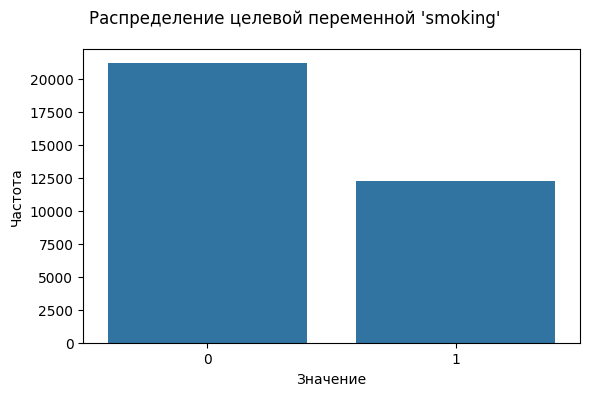

In [9]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(df[TARGET].value_counts(), ax=ax)
ax.set_xlabel("Значение")
ax.set_ylabel("Частота")

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

В распределении целевого признака преобладает доля некурящих людей.

### Распределение числовых переменных

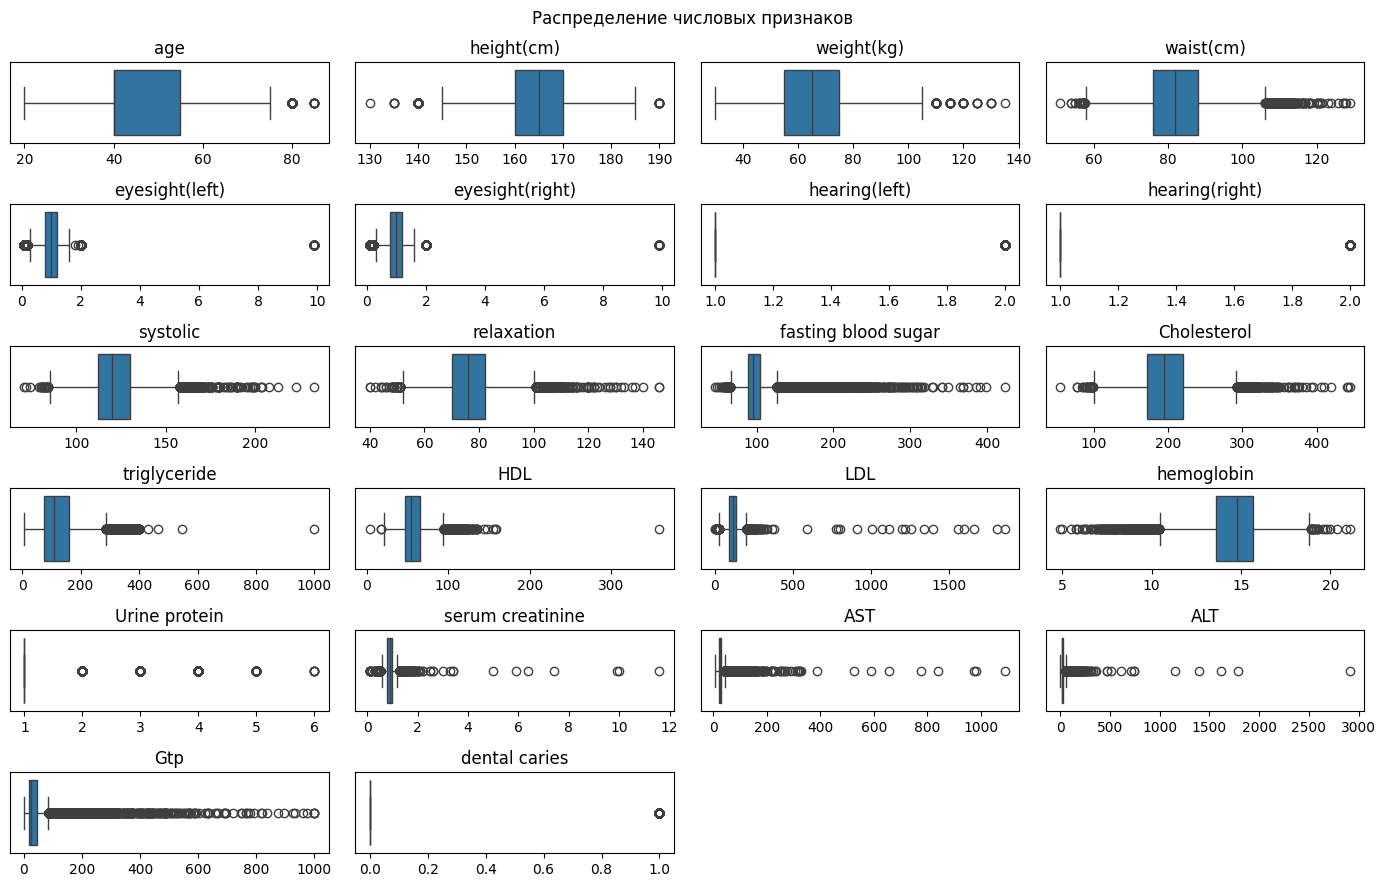

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(14, 9))

for i, col in enumerate([col for col in df.columns if col != TARGET]):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(df.columns) - 1, len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков")
plt.tight_layout()
plt.show()

Можно видеть, что числовые переменные имеют широкие диапазоны изменений, которые нельзя однозначно отнести к выбросам, оставим признаки без изменений.

### Построение информативных графиков

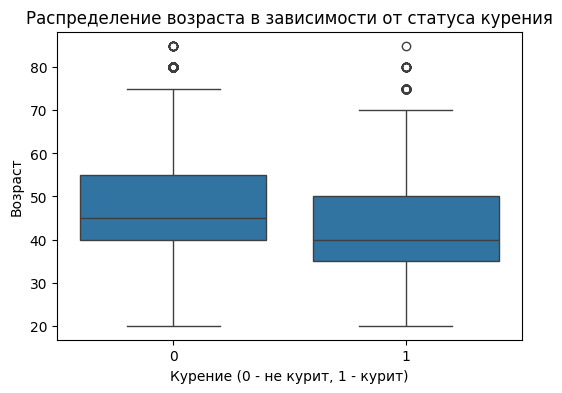

In [11]:
# Зависимости возраста от статуса курения
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoking"], y=df["age"])
plt.title("Распределение возраста в зависимости от статуса курения")
plt.xlabel("Курение (0 - не курит, 1 - курит)")
plt.ylabel("Возраст")
plt.show()

Можно видеть, что отказ от курения немного увеличивает продолжительность жизни.

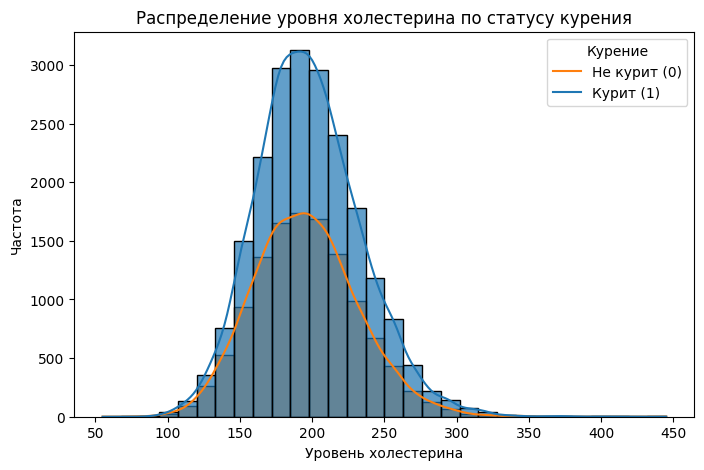

In [12]:
# Распределение уровня холестерина в зависимости от статуса курения
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Cholesterol", hue="smoking", kde=True, bins=30, alpha=0.7)
plt.title("Распределение уровня холестерина по статусу курения")
plt.xlabel("Уровень холестерина")
plt.ylabel("Частота")
plt.legend(title="Курение", labels=["Не курит (0)", "Курит (1)"])
plt.show()

Факт курения практически не влияет на уровень холестерина.

### Анализ корреляций

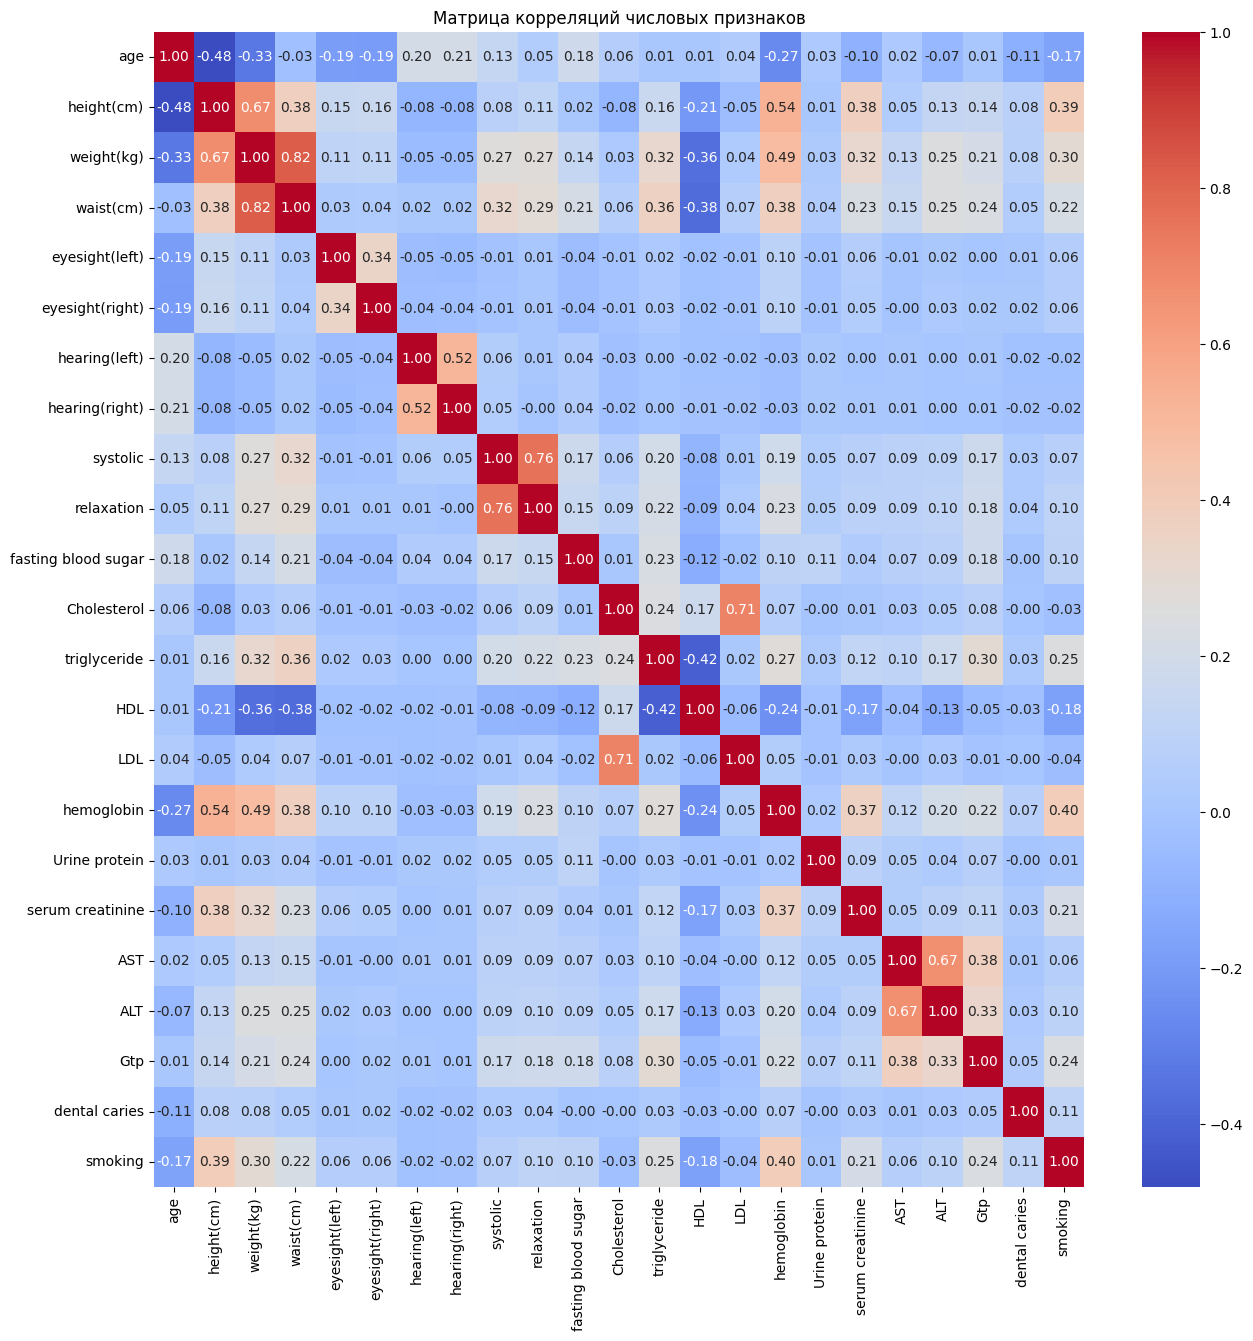

In [13]:
# Матрица корреляций
plt.figure(figsize=(15, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

В данных присутствуют ожидаемые корреляции между height-weight, weight-weist, ALT-AST, Cholesterol-LDL, relaxation-systolic, hearing(left)-hearing(right). Оставим данные без изменений.

### Разделение данных

In [14]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test_poly.shape={y_test.shape}")

X_train.shape=(26773, 22), y_train.shape=(26773,)
X_test.shape=(6694, 22), y_test_poly.shape=(6694,)


## Обучение моделей

In [15]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    param_dist = {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "max_depth": [3, 5, 10, 20, 30, 40, 50, 100],
        "min_samples_split": [2, 5, 10, 20, 50],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["auto", "sqrt", "log2", None],
    }

    gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
    random_search = RandomizedSearchCV(
        gbc, param_dist, n_iter=300, cv=5, n_jobs=-1, scoring="f1"
    )
    random_search.fit(X_train, y_train)

    print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}

In [16]:
# Лучшая модель
best_params = {
    "subsample": 0.7,
    "n_estimators": 100,
    "min_samples_split": 20,
    "min_samples_leaf": 20,
    "max_features": "log2",
    "max_depth": 5,
    "learning_rate": 0.1,
}
best_gbc = GradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)
best_gbc.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = best_gbc.predict(X_test)
y_prob = best_gbc.predict_proba(X_test)[:, 1]

### Оценка качества моделей

In [17]:
def get_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, roc_auc


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": ["accuracy", "precision", "recall", "f1", "roc_auc"],
        "GradientBoostingClassifier": [
            *map(lambda x: round(x, 2), get_metrics(y_test, y_pred, y_prob))
        ],
        "RandomForestClassifier": [0.75, 0.66, 0.64, 0.65, 0.83],
        "LogisticRegression": [0.69, 0.57, 0.69, 0.63, 0.77],
        "DecisionTreeClassifier": [0.72, 0.62, 0.62, 0.62, 0.79],
        "SVC": [0.74, 0.66, 0.62, 0.64, 0.82],
    }
)

quality_comparison

,Metrics,GradientBoostingClassifier,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,SVC
0,accuracy,0.75,0.75,0.69,0.72,0.74
1,precision,0.67,0.66,0.57,0.62,0.66
2,recall,0.65,0.64,0.69,0.62,0.62
3,f1,0.66,0.65,0.63,0.62,0.64
4,roc_auc,0.83,0.83,0.77,0.79,0.82


Полученные метрики показывают, что модель градиентного бустинга обладает наибольшей точность классификации по сравнению с остальными.

# Задача 2. Регрессия

## Константы

In [18]:
TRAIN_PATH = "../Lesson36/train.csv"
TARGET = "Premium Amount"
RANDOM_STATE = 777
TEST_SIZE = 0.2

## Загрузка данных

In [19]:
df = pd.read_csv(TRAIN_PATH, index_col="id")

print("Train DataFrame")
df.head()

Train DataFrame


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

## Исследовательский анализ данных

In [21]:
# Удалим колонку с датой
df = df.drop(columns=["Policy Start Date"])

# Выделим числовые и категориальные признаки
numeric_columns = [
    col for col in df.columns if df[col].dtype == "float64" if col != TARGET
]
categoric_columns = [col for col in df.columns if df[col].dtype == "object"]

In [22]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats


def categoric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Количество уникальных значений"] = df.nunique()
    stats["Мода"] = df.mode().transpose()

    return stats

In [23]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Age,1.558750e-02,18.00,64.00,41.15,41.00,1.833300e+02,22.00,60.00,30.00,53.00
Annual Income,3.745750e-02,1.00,149997.00,32745.22,23911.00,1.035521e+09,2627.00,81075.00,8001.00,44634.00
Number of Dependents,9.139333e-02,0.00,4.00,2.01,2.00,2.010000e+00,0.00,4.00,1.00,3.00
Health Score,6.173000e-02,2.01,58.98,25.61,24.58,1.489200e+02,9.94,43.28,15.92,34.53
Previous Claims,3.033575e-01,0.00,9.00,1.00,1.00,9.700000e-01,0.00,2.00,0.00,2.00
Vehicle Age,5.000000e-06,0.00,19.00,9.57,10.00,3.336000e+01,2.00,18.00,5.00,15.00
Credit Score,1.149017e-01,300.00,849.00,592.92,595.00,2.249458e+04,383.00,792.00,468.00,721.00
Insurance Duration,8.333333e-07,1.00,9.00,5.02,5.00,6.730000e+00,1.00,9.00,3.00,7.00
Premium Amount,0.000000e+00,20.00,4999.00,1102.54,872.00,7.482230e+05,150.00,2363.00,514.00,1509.00


In [24]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly
Property Type,0.000000,3,House


Данные содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

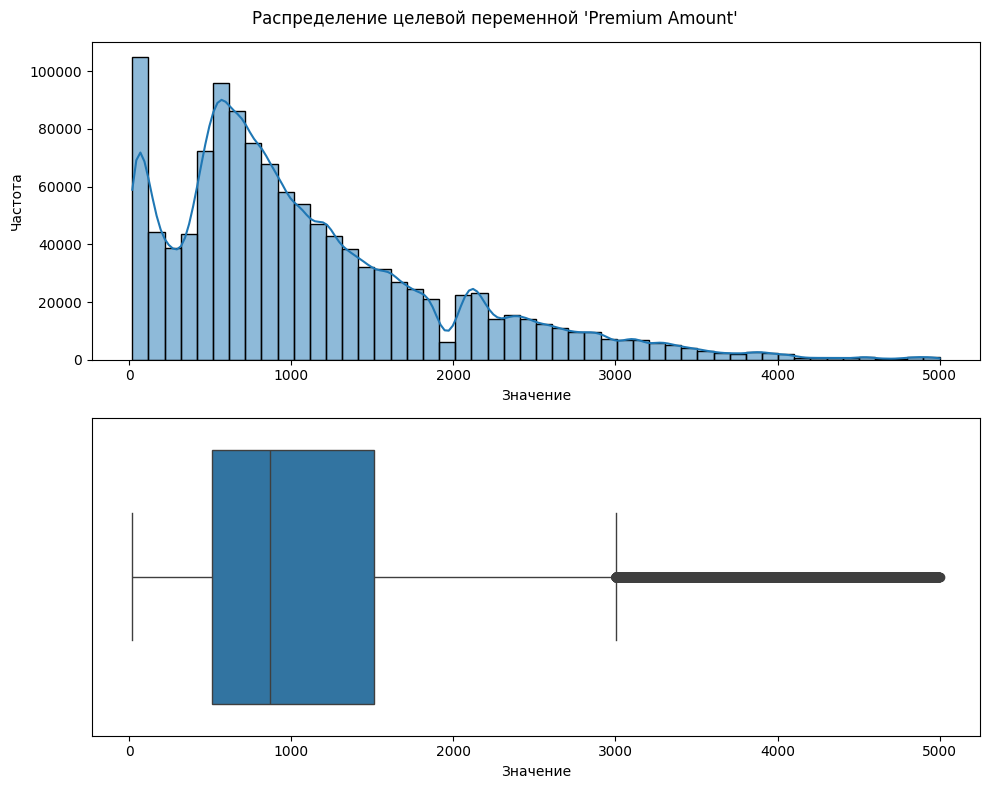

In [25]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df[TARGET], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df[TARGET], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

Распределение целевого признака похоже на распределение Пуассона с тяжелым хвостом, оставим его без изменения.

### Обработка пропусков

Заменим пропуски числовых переменных на значение медианы, а категориальных на значение моды.

In [26]:
# Заполняем числовые переменные
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Заполняем категориальные переменные
# Для случая если встретятся 2 значения с одинаковой частотой, берем первое из них x.mode()[0]
df[categoric_columns] = df[categoric_columns].apply(lambda x: x.fillna(x.mode()[0]))

### Обработка выбросов

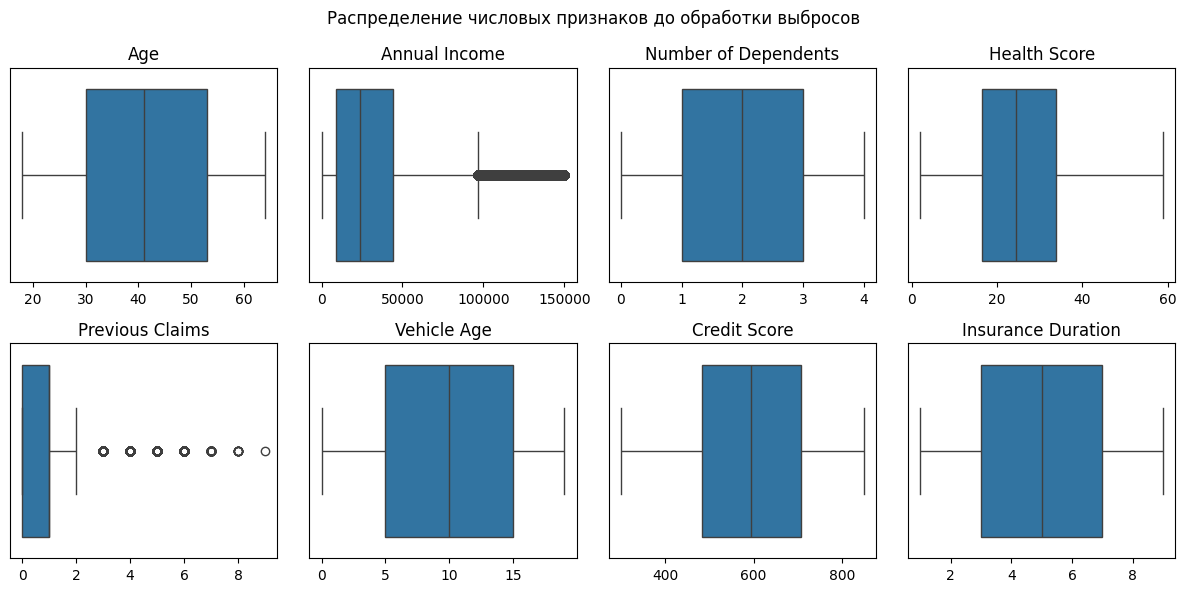

In [27]:
# Отображение распределения числовых признаков до обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение числовых признаков до обработки выбросов")
plt.tight_layout()
plt.show()

Больше всего выбросов содержит признак "Annual Income", в нем встречаются как экстримально малые значения (около 1.0) так и очень высокие, выше 100000.0. Заменим низкие значения на величину квантиля 0.1, а высокие на значение межквартильного интервала. Признак "Previus Claims" оставим без изменений, т.к. он дает информацию об особенностях поведения клиентов.

In [28]:
# Функция для обработки выбросов
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = df[col].quantile(0.1)
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df


df = remove_outliers(df, ["Annual Income"])

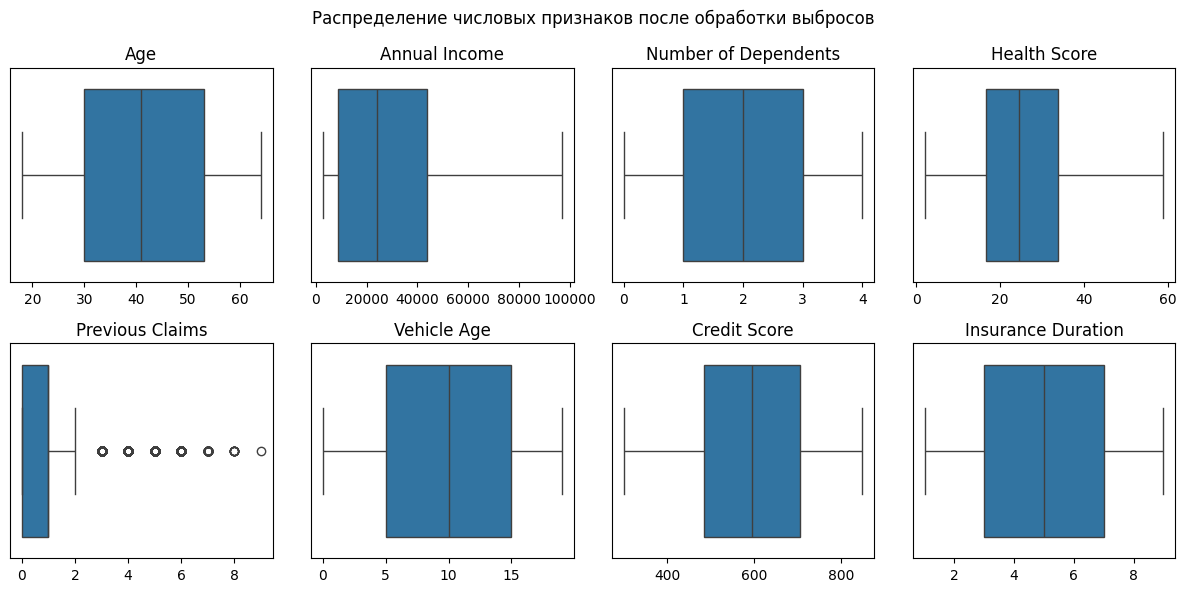

In [29]:
# Отображение распределения числовых признаков после обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение числовых признаков после обработки выбросов")
plt.tight_layout()
plt.show()

Выбросы удалены.

EDA после обработки признаков.

In [30]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Age,0.0,18.00,64.00,41.14,41.00,1.804700e+02,22.00,60.00,30.00,53.00
Annual Income,0.0,2699.00,96871.00,31122.85,23911.00,7.576032e+08,2699.00,79448.10,8646.00,43936.00
Number of Dependents,0.0,0.00,4.00,2.01,2.00,1.830000e+00,0.00,4.00,1.00,3.00
Health Score,0.0,2.01,58.98,25.55,24.58,1.397900e+02,10.19,42.85,16.55,33.77
Previous Claims,0.0,0.00,9.00,1.00,1.00,6.700000e-01,0.00,2.00,0.00,1.00
Vehicle Age,0.0,0.00,19.00,9.57,10.00,3.336000e+01,2.00,18.00,5.00,15.00
Credit Score,0.0,300.00,849.00,593.16,595.00,1.991035e+04,393.00,787.00,484.00,706.00
Insurance Duration,0.0,1.00,9.00,5.02,5.00,6.730000e+00,1.00,9.00,3.00,7.00
Premium Amount,0.0,20.00,4999.00,1102.54,872.00,7.482230e+05,150.00,2363.00,514.00,1509.00


In [31]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0,2,Male
Marital Status,0.0,3,Single
Education Level,0.0,4,Master's
Occupation,0.0,3,Employed
Location,0.0,3,Suburban
Policy Type,0.0,3,Premium
Customer Feedback,0.0,3,Average
Smoking Status,0.0,2,Yes
Exercise Frequency,0.0,4,Weekly
Property Type,0.0,3,House


### Кодирование категориальных переменных

In [32]:
# Кодируем методом OneHotEncoding
df = pd.get_dummies(df, columns=categoric_columns, drop_first=True, dtype=int)

df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
id,,,,,,,,,,,,,,,,,,,,,
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2869.0,0,...,0,1,0,1,0,0,0,1,0,1
1,39.0,31678.0,3.0,15.569731,1.0,12.0,694.0,2.0,1483.0,0,...,1,0,0,0,1,1,0,0,0,1
2,23.0,25602.0,3.0,47.177549,1.0,14.0,595.0,3.0,567.0,1,...,0,1,1,0,1,0,0,1,0,1
3,21.0,96871.0,2.0,10.938144,1.0,0.0,367.0,1.0,765.0,1,...,0,0,0,1,1,0,0,0,0,0
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2022.0,1,...,0,1,0,1,1,0,0,1,0,1


### Анализ корреляций

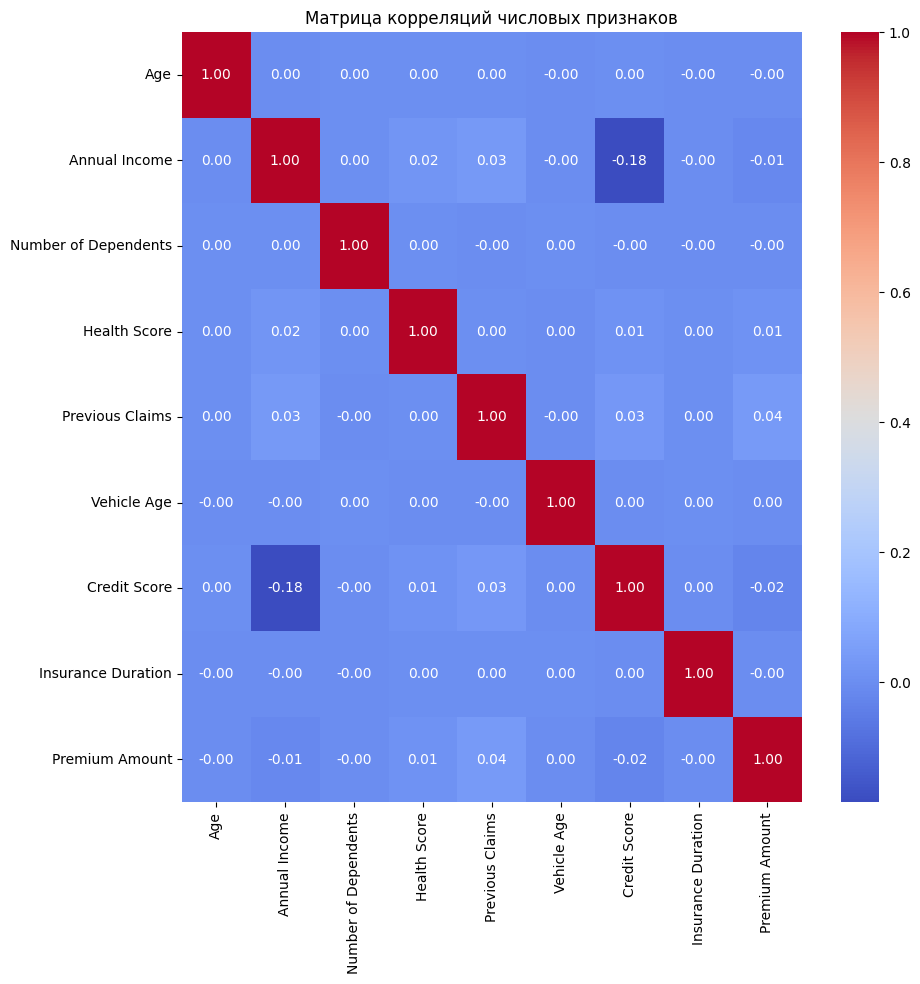

In [33]:
# Матрица корреляций
plt.figure(figsize=(10, 10))
correlation_matrix = df[numeric_columns + [TARGET]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

Заметные корреляции отсутствуют.

### Разделение данных

In [34]:
# Признаки без нормализации
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")

X_train.shape=(960000, 28), y_train.shape=(960000,)
X_test.shape=(240000, 28), y_test.shape=(240000,)


## Подбор гиперпараметров

In [35]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    # Уменьшим количество обучающих данных, чтобы подбор параметров проходи быстрее.
    X_train_sample = X_train.sample(
        frac=0.025, random_state=RANDOM_STATE, replace=False
    )
    y_train_sample = y_train.sample(
        frac=0.025, random_state=RANDOM_STATE, replace=False
    )

    print(
        f"X_train_sample.shape={X_train_sample.shape}, y_train_sample.shape={y_train_sample.shape}"
    )

    param_dist = {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "max_depth": [3, 5, 10, 20, 30, 40, 50, 100],
        "min_samples_split": [2, 5, 10, 20, 50],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["auto", "sqrt", "log2", None],
    }

    gbr_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    random_search = RandomizedSearchCV(
        gbr_model,
        param_dist,
        n_iter=300,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
    )
    random_search.fit(X_train_sample, y_train_sample)

    print("Найденные гиперпараметры:", random_search.best_params_)

Найденные гиперпараметры: {"subsample": 0.8, "n_estimators": 100, "min_samples_split": 50, "min_samples_leaf": 5, "max_features": None, "max_depth": 20, "learning_rate": 0.01}

In [36]:
# Модель после подбора гиперпараметров
params_fine_tune = {
    "subsample": 0.8,
    "n_estimators": 100,
    "min_samples_split": 50,
    "min_samples_leaf": 5,
    "max_features": None,
    "max_depth": 20,
    "learning_rate": 0.01,
}
gbr_fine_tune = GradientBoostingRegressor(**params_fine_tune, random_state=RANDOM_STATE)
gbr_fine_tune.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred_gbr = gbr_fine_tune.predict(X_test)

## Оценка качества

In [37]:
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    return {"mae": mae, "mse": mse, "rmse": rmse}


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": [*get_metrics(y_test, y_pred_gbr).keys()],
        "GradientBoostingRegressor": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_gbr).values(),
            )
        ],
        "RandomForestRegressor": [641.53, 714772.97, 845.44],
        "DecisionTreeRegressor": [654.49, 729423.31, 854.06],
        "SVR": [638.05, 805862.08, 897.70],
        "KNeighborsRegressor": [718.22, 884268.14, 940.36],
        "LinearRegression": [667.81, 748116.66, 864.94],
    }
)

quality_comparison

,Metrics,GradientBoostingRegressor,RandomForestRegressor,DecisionTreeRegressor,SVR,KNeighborsRegressor,LinearRegression
0,mae,649.61,641.53,654.49,638.05,718.22,667.81
1,mse,718619.47,714772.97,729423.31,805862.08,884268.14,748116.66
2,rmse,847.71,845.44,854.06,897.70,940.36,864.94


Модель градиентного бустинга демострирует точность, сопоставимую с моделью случайного леса и моделью опорных векторов, однако немного уступает им.